In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import RelaxedOneHotCategorical, MultivariateNormalDiag, Dirichlet, OneHotCategorical, MultivariateNormalFullCovariance
from functools import reduce
import time
import distributions
from build_dataset import build_dataset_2dim_Kclass_gmm
from visualize_tools import circle, ellipse, covariance_ellipse, change_aspect_ratio

In [3]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [4]:
N = 200
K = 3
mean_true = [[-3.0,-3.0], [-1.0,6.0] , [5.0,-1.0]]
covariance_true = [[[1.0,0.0],[0.0,1.0]],
       [[0.8,0.1],[0.1,0.8]],
       [[1.2,-0.2],[-0.2,1.2]]]
mix_true  = np.array([ 0.2 , 0.4, 0.4 ])
x_data, label,mix = build_dataset_2dim_Kclass_gmm(N,K,mean_true,covariance_true,mix_true)

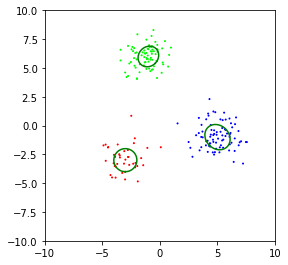

In [5]:
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="green")
    #plt.plot(ex*2+mean_true[k][0],ey*2+mean_true[k][1],color="green")
    #plt.plot(ex*3+mean_true[k][0],ey*3+mean_true[k][1],color="green")
color=["#FF0000","#00FF00","#0000FF"]
area = [[1.0]*N]
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],s = area, color=color[label[n]])
plt.show()

In [8]:
def gmm_bbvi_z_pi(N,mu,cov,x_data,label,n_iter):
    start = time.time()

    mu = tf.constant(mu, dtype = tf.float32)
    sigma = tf.constant(cov, dtype = tf.float32)

    #generative model 
    alpha = tf.constant([1.0, 1.0, 1.0])
    pi = Dirichlet(concentration = alpha)
    z = [OneHotCategorical(probs = pi, dtype = tf.float32) for n in range(N)]
    x = [MultivariateNormalFullCovariance(loc = sum([mu[k]*z[n][k] for k in range(K)]),covariance_matrix = sum([sigma[k]*z[n][k] for k in range(K)])) for n in range(N)]
    print("generative model")
    #variational model
    lambda_pi = tf.nn.softplus(tf.Variable([0.0 , 0.0 , 0.0]))
    qpi = Dirichlet(concentration = lambda_pi)
    y = [tf.Variable([0.0,0.0,0.0], dtype = tf.float32) for n in range(N)]
    lambda_z = [tf.nn.softmax(y[n]) for n in range(N)]
    temp = tf.nn.softplus(tf.Variable(10.0)) 
    #qz = [OneHotCategorical(probs = lambda_z[n], dtype = tf.float32) for n in range(N)]
    qz = [RelaxedOneHotCategorical(temp,probs = lambda_z[n], dtype = tf.float32) for n in range(N)]
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[pi] = qpi
    
    x_ph =  [tf.placeholder(tf.float32,[2]) for n in range(N)]
    #data = {x[n]:x_data[n] for n in range(N)}
    data = {x[n]:x_ph[n] for n in range(N)}
    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    print("inference")
    print(time.time()-start)
    sess = ed.get_session()
    tf.global_variables_initializer().run()
    loss =[]
    variational_parameter=[]
    variational_parameter.append(sess.run([lambda_pi,temp,lambda_z]))
    for _ in range(inference.n_iter):
        info_dict = inference.update(feed_dict = {x_ph[n]:x_data[n] for n in range(N)})
        loss.append(info_dict['loss'])
        variational_parameter.append(sess.run([lambda_pi,temp,lambda_z]))
    print(time.time()-start)
    return loss,variational_parameter                             
                                 

In [16]:
loss,variational_parameter = gmm_bbvi_z_pi(N,mean_true,covariance_true,x_data,label,10000)

generative model
variational model
inference
185.46332001686096
1947.8029565811157


<IPython.core.display.Javascript object>


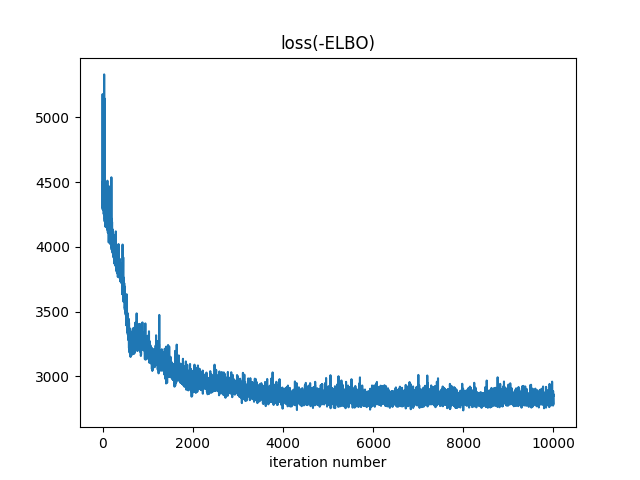

In [17]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()

<IPython.core.display.Javascript object>


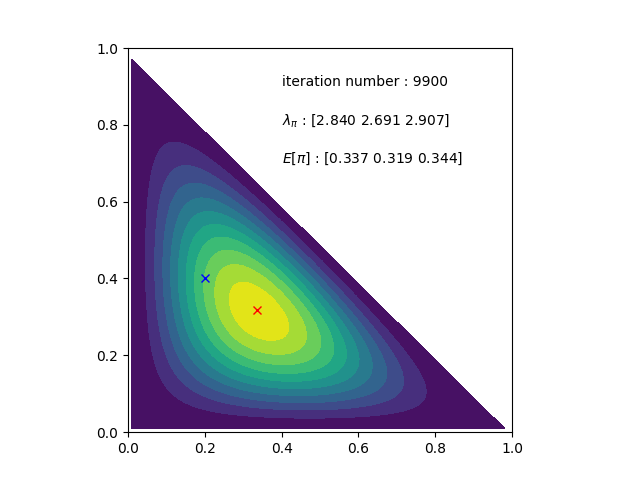

In [19]:
%matplotlib nbagg
import scipy.stats as ss
import matplotlib.tri as mtri
from matplotlib import cm
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
plt.gca().set_aspect('equal', adjustable='box')
X = []
Y = []

for x in np.arange(0.01,0.99,0.01):
    for y in  np.arange(0.01,0.99-x,0.01):
        X.append(x)
        Y.append(y)
triang = mtri.Triangulation(X, Y)

plt.plot(mix_true[0],mix_true[1],"bx")
artists = []
for t,vp in enumerate(variational_parameter):
    if t %100 == 0:
        dc = ss.dirichlet(np.array(vp[0]))
        
        Z = []
        for x,y in zip(X,Y):
            Z.append(dc.pdf((x,y)))

        sum_pi = vp[0][0]+vp[0][1]+vp[0][2]
        exp = vp[0]/sum_pi
            
        text = [plt.text(0.4,0.9,"iteration number : "+str(t)),
                    plt.text(0.4,0.8,"$\lambda_\pi$ : ["+"{0:.3f}".format(vp[0][0]) + " {0:.3f}".format(vp[0][1]) + " {0:.3f}]".format(vp[0][2])),
                    plt.text(0.4,0.7,"$E[\pi]$ : ["+"{0:.3f}".format(exp[0]) + " {0:.3f}".format(exp[1]) + " {0:.3f}]".format(exp[2]))]

        im_pi = ax.tricontourf(triang, Z,10)
        

        e = plt.plot(exp[0],exp[1],"rx")
        
        artists.append(im_pi.collections+text+e)
ani=animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("gmm_2dim_3class_pi.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


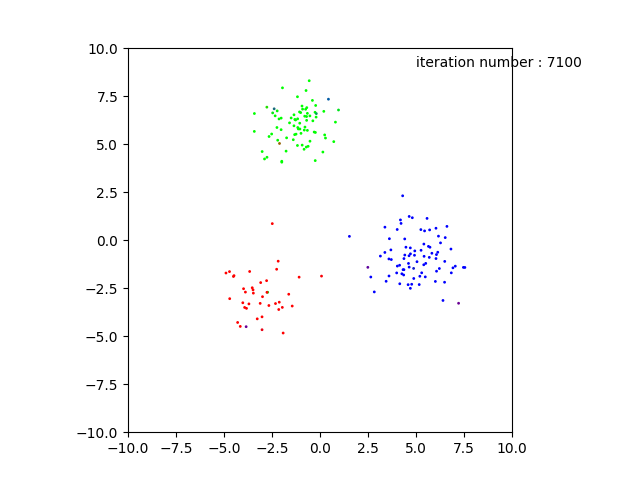

In [20]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    #plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
    #plt.plot(ex*2+mean_true[k][0],ey*2+mean_true[k][1],color="black")
    #plt.plot(ex*3+mean_true[k][0],ey*3+mean_true[k][1],color="black")
artists = []
area = [[1.0]*N]
for t,vp in enumerate(variational_parameter):
    if t % 100 == 0 :
        text = [plt.text(5.0,9.0,"iteration number : "+str(t))]
        im_z=plt.scatter(x_data.T[0],x_data.T[1],s = area, color=vp[2])
        artists.append([im_z]+text)
ani=animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("gmm_2dim_3class_z.gif", writer='imagemagick', fps=4)

In [18]:
print(x_data[1],label[1])
for t,vp in enumerate(variational_parameter):
    print(t,vp[1],vp[2][1])

[ 4.22139406  0.86392254] 2
0 10.0 [ 0.33333334  0.33333334  0.33333334]
1 9.90005 [ 0.37915242  0.31042376  0.31042373]
2 9.82231 [ 0.42027548  0.28372163  0.29600284]
3 9.79346 [ 0.45801559  0.25490627  0.28707808]
4 9.80946 [ 0.48812911  0.24332315  0.26854777]
5 9.82713 [ 0.524032    0.22814089  0.24782713]
6 9.85144 [ 0.54735047  0.22501253  0.22763695]
7 9.8809 [ 0.57545573  0.21664789  0.20789635]
8 9.88824 [ 0.59224862  0.20495941  0.202792  ]
9 9.87885 [ 0.61124855  0.19207236  0.19667912]
10 9.89271 [ 0.63295168  0.18010902  0.18693933]
11 9.90578 [ 0.64469153  0.17029768  0.18501081]
12 9.93782 [ 0.65144289  0.1605317   0.18802539]
13 9.9325 [ 0.65167391  0.15301083  0.19531523]
14 9.92448 [ 0.64886558  0.14835262  0.20278177]
15 9.9311 [ 0.6424619   0.14676689  0.21077122]
16 9.92414 [ 0.64007998  0.14507546  0.21484448]
17 9.90531 [ 0.63637078  0.14414383  0.21948536]
18 9.87346 [ 0.62859833  0.14385195  0.22754976]
19 9.85501 [ 0.61635512  0.14579944  0.23784544]
20 9.836

349 9.53835 [ 0.08569038  0.1190344   0.79527527]
350 9.54699 [ 0.08907196  0.1155749   0.79535306]
351 9.56392 [ 0.09285615  0.11374564  0.7933982 ]
352 9.58499 [ 0.09775635  0.11222202  0.79002166]
353 9.61209 [ 0.10098572  0.11094469  0.78806955]
354 9.64456 [ 0.10307541  0.11038037  0.78654426]
355 9.65003 [ 0.10465699  0.10959797  0.78574508]
356 9.64058 [ 0.1062706   0.10831003  0.78541934]
357 9.63645 [ 0.10802977  0.10760371  0.78436649]
358 9.62997 [ 0.10902665  0.10665656  0.78431672]
359 9.63288 [ 0.11035426  0.10638515  0.78326058]
360 9.65229 [ 0.11153476  0.10613764  0.78232759]
361 9.67744 [ 0.11190879  0.10733817  0.78075308]
362 9.69526 [ 0.11334765  0.10802754  0.77862483]
363 9.69662 [ 0.11419459  0.11082877  0.77497661]
364 9.70307 [ 0.11488358  0.11474659  0.77036983]
365 9.7118 [ 0.11735106  0.11776534  0.76488358]
366 9.71609 [ 0.11946198  0.12271656  0.7578215 ]
367 9.72269 [ 0.12230179  0.12819159  0.74950659]
368 9.72636 [ 0.12588416  0.13292524  0.74119055]
3

669 7.37951 [ 0.00240717  0.02012087  0.97747201]
670 7.41603 [ 0.00233595  0.01997594  0.97768813]
671 7.44197 [ 0.00224672  0.01960774  0.97814548]
672 7.4646 [ 0.00217664  0.01947593  0.97834742]
673 7.48468 [ 0.00213181  0.01948198  0.97838622]
674 7.49002 [ 0.00209441  0.01933637  0.97856927]
675 7.48626 [ 0.00207224  0.0192892   0.97863859]
676 7.48431 [ 0.0020719   0.01926556  0.97866255]
677 7.49179 [ 0.0020605   0.01919178  0.97874773]
678 7.50897 [ 0.00207071  0.01908022  0.97884905]
679 7.53013 [ 0.00209946  0.01905393  0.97884661]
680 7.55542 [ 0.00215031  0.01901298  0.97883672]
681 7.57343 [ 0.00222219  0.0189781   0.9787997 ]
682 7.57585 [ 0.00230123  0.01892849  0.97877026]
683 7.57505 [ 0.00239112  0.01898321  0.97862566]
684 7.57063 [ 0.00248265  0.01899454  0.97852284]
685 7.55935 [ 0.00257068  0.01921836  0.97821099]
686 7.54419 [ 0.00263485  0.01926842  0.97809678]
687 7.53477 [ 0.0027085   0.01939517  0.97789633]
688 7.52439 [ 0.0027696   0.01963149  0.97759891]
6

1002 8.80926 [  4.63327044e-04   4.85838670e-03   9.94678259e-01]
1003 8.81229 [  4.58754279e-04   4.91056871e-03   9.94630694e-01]
1004 8.81237 [  4.58010356e-04   4.96987067e-03   9.94572103e-01]
1005 8.81336 [  4.57866205e-04   5.03556104e-03   9.94506538e-01]
1006 8.81472 [  4.55493049e-04   5.06545231e-03   9.94479060e-01]
1007 8.81491 [  4.54352732e-04   5.13371872e-03   9.94411886e-01]
1008 8.81623 [  4.49624058e-04   5.17719006e-03   9.94373202e-01]
1009 8.81947 [  4.44532750e-04   5.23469970e-03   9.94320750e-01]
1010 8.82187 [  4.40765201e-04   5.28194895e-03   9.94277298e-01]
1011 8.82911 [  4.37370734e-04   5.36372233e-03   9.94198918e-01]
1012 8.83925 [  4.33490583e-04   5.46240993e-03   9.94104087e-01]
1013 8.84568 [  4.31098510e-04   5.59069077e-03   9.93978262e-01]
1014 8.8427 [  4.29926615e-04   5.75179746e-03   9.93818223e-01]
1015 8.83491 [  4.25422651e-04   5.87765593e-03   9.93696988e-01]
1016 8.82693 [  4.21762554e-04   6.04167767e-03   9.93536532e-01]
1017 8.8182

1174 8.90771 [  2.98475585e-04   5.06693078e-03   9.94634628e-01]
1175 8.9194 [  2.97104823e-04   5.02237817e-03   9.94680464e-01]
1176 8.92842 [  2.94351397e-04   4.98545868e-03   9.94720221e-01]
1177 8.93247 [  2.92818208e-04   4.98212269e-03   9.94725049e-01]
1178 8.93088 [  2.93163583e-04   4.96859709e-03   9.94738281e-01]
1179 8.92636 [  2.95561826e-04   4.95284330e-03   9.94751632e-01]
1180 8.91931 [  2.97843828e-04   4.96492581e-03   9.94737208e-01]
1181 8.90786 [  2.98803148e-04   4.94501274e-03   9.94756222e-01]
1182 8.89358 [  3.01470194e-04   4.92557744e-03   9.94772971e-01]
1183 8.8794 [  3.02711385e-04   4.92584659e-03   9.94771421e-01]
1184 8.86705 [  3.04673187e-04   4.96132206e-03   9.94734049e-01]
1185 8.86002 [  3.05452500e-04   5.01672551e-03   9.94677782e-01]
1186 8.84915 [  3.06042086e-04   5.09488722e-03   9.94599104e-01]
1187 8.83891 [  3.08616378e-04   5.18020941e-03   9.94511127e-01]
1188 8.83176 [  3.13326309e-04   5.26478747e-03   9.94421899e-01]
1189 8.83199

1521 9.07796 [  1.67561622e-04   6.37788838e-03   9.93454576e-01]
1522 9.06464 [  1.67127160e-04   6.36244984e-03   9.93470430e-01]
1523 9.05523 [  1.66826270e-04   6.36794977e-03   9.93465245e-01]
1524 9.04764 [  1.67418286e-04   6.36874838e-03   9.93463814e-01]
1525 9.03661 [  1.68082639e-04   6.40158914e-03   9.93430316e-01]
1526 9.02889 [  1.68093058e-04   6.40247529e-03   9.93429482e-01]
1527 9.02275 [  1.67951861e-04   6.38853433e-03   9.93443489e-01]
1528 9.0117 [  1.67963401e-04   6.40936801e-03   9.93422687e-01]
1529 9.0004 [  1.67767110e-04   6.42094621e-03   9.93411243e-01]
1530 8.99216 [  1.68110899e-04   6.45238720e-03   9.93379474e-01]
1531 8.98679 [  1.68569837e-04   6.49108272e-03   9.93340313e-01]
1532 8.98318 [  1.68324506e-04   6.49614213e-03   9.93335485e-01]
1533 8.97787 [  1.67229926e-04   6.46220986e-03   9.93370533e-01]
1534 8.97436 [  1.66177735e-04   6.46734657e-03   9.93366420e-01]
1535 8.97175 [  1.65430334e-04   6.49060821e-03   9.93343949e-01]
1536 8.96999

1740 9.04 [  8.49664357e-05   3.69720487e-03   9.96217787e-01]
1741 9.03551 [  8.44034657e-05   3.69099970e-03   9.96224642e-01]
1742 9.03007 [  8.36268155e-05   3.67300445e-03   9.96243358e-01]
1743 9.02398 [  8.26725154e-05   3.65638430e-03   9.96260941e-01]
1744 9.02042 [  8.17072141e-05   3.63404071e-03   9.96284306e-01]
1745 9.01293 [  8.07112374e-05   3.60388053e-03   9.96315420e-01]
1746 9.0049 [  8.00640628e-05   3.57291452e-03   9.96347010e-01]
1747 9.00077 [  7.95069718e-05   3.55217746e-03   9.96368289e-01]
1748 8.99751 [  7.88880352e-05   3.53368442e-03   9.96387482e-01]
1749 8.99683 [  7.84769436e-05   3.52965132e-03   9.96391833e-01]
1750 8.99673 [  7.84153599e-05   3.52427387e-03   9.96397316e-01]
1751 8.99653 [  7.83166688e-05   3.51336761e-03   9.96408284e-01]
1752 8.99771 [  7.84516524e-05   3.49835609e-03   9.96423185e-01]
1753 8.99865 [  7.84475633e-05   3.48851574e-03   9.96433020e-01]
1754 8.99818 [  7.84321383e-05   3.46879126e-03   9.96452808e-01]
1755 9.00204 [

2168 9.25894 [  6.04018060e-05   1.46113778e-03   9.98478472e-01]
2169 9.2553 [  6.03109220e-05   1.46976009e-03   9.98469889e-01]
2170 9.25323 [  6.03872104e-05   1.47780450e-03   9.98461843e-01]
2171 9.25151 [  6.04083252e-05   1.48858514e-03   9.98450994e-01]
2172 9.24885 [  6.04448833e-05   1.49764202e-03   9.98441875e-01]
2173 9.24719 [  6.06626381e-05   1.50627457e-03   9.98433053e-01]
2174 9.24565 [  6.08898117e-05   1.51137542e-03   9.98427749e-01]
2175 9.2441 [  6.09645103e-05   1.51363784e-03   9.98425364e-01]
2176 9.2424 [  6.09351991e-05   1.51676813e-03   9.98422265e-01]
2177 9.24322 [  6.08845075e-05   1.52314303e-03   9.98415947e-01]
2178 9.24485 [  6.07501133e-05   1.52822142e-03   9.98411059e-01]
2179 9.24693 [  6.05871573e-05   1.53636176e-03   9.98403013e-01]
2180 9.24956 [  6.05791975e-05   1.54376810e-03   9.98395622e-01]
2181 9.25241 [  6.03746266e-05   1.54496403e-03   9.98394668e-01]
2182 9.25427 [  6.01531938e-05   1.54597161e-03   9.98393834e-01]
2183 9.25513 

2301 9.29277 [  6.06751382e-05   1.53874233e-03   9.98400629e-01]
2302 9.29322 [  6.03161425e-05   1.53193378e-03   9.98407781e-01]
2303 9.29393 [  5.99885389e-05   1.52721151e-03   9.98412728e-01]
2304 9.29436 [  5.97613835e-05   1.52189867e-03   9.98418331e-01]
2305 9.29569 [  5.96500031e-05   1.51828234e-03   9.98422027e-01]
2306 9.2958 [  5.96150057e-05   1.51401048e-03   9.98426437e-01]
2307 9.29547 [  5.96157224e-05   1.50959461e-03   9.98430789e-01]
2308 9.29551 [  5.96461177e-05   1.50902802e-03   9.98431265e-01]
2309 9.29684 [  5.95553283e-05   1.50459609e-03   9.98435795e-01]
2310 9.29996 [  5.93999321e-05   1.49873062e-03   9.98441875e-01]
2311 9.30112 [  5.93279510e-05   1.49451662e-03   9.98446167e-01]
2312 9.30296 [  5.93997356e-05   1.49050576e-03   9.98450041e-01]
2313 9.30531 [  5.94434387e-05   1.49038725e-03   9.98450160e-01]
2314 9.30845 [  5.94734556e-05   1.49374956e-03   9.98446763e-01]
2315 9.30957 [  5.94926751e-05   1.49873772e-03   9.98441756e-01]
2316 9.3112

2515 9.45362 [  3.12469056e-05   1.13514788e-03   9.98833597e-01]
2516 9.45316 [  3.11803924e-05   1.13564020e-03   9.98833239e-01]
2517 9.45196 [  3.11503027e-05   1.13770284e-03   9.98831093e-01]
2518 9.45063 [  3.11021140e-05   1.14108925e-03   9.98827755e-01]
2519 9.44744 [  3.09875832e-05   1.14164071e-03   9.98827398e-01]
2520 9.44517 [  3.09108436e-05   1.14267378e-03   9.98826444e-01]
2521 9.44245 [  3.08135241e-05   1.14411756e-03   9.98825014e-01]
2522 9.44067 [  3.07630107e-05   1.14463759e-03   9.98824537e-01]
2523 9.4399 [  3.07238770e-05   1.14726205e-03   9.98822033e-01]
2524 9.43931 [  3.07033915e-05   1.14865287e-03   9.98820603e-01]
2525 9.43862 [  3.06777729e-05   1.14988722e-03   9.98819411e-01]
2526 9.43698 [  3.06846523e-05   1.15266908e-03   9.98816729e-01]
2527 9.43593 [  3.07107111e-05   1.15434348e-03   9.98814940e-01]
2528 9.43462 [  3.07284936e-05   1.15821243e-03   9.98811126e-01]
2529 9.43258 [  3.07790069e-05   1.16260222e-03   9.98806596e-01]
2530 9.4301

2844 9.43564 [  3.16175174e-05   9.59696481e-04   9.99008715e-01]
2845 9.43598 [  3.16140540e-05   9.58648277e-04   9.99009728e-01]
2846 9.43607 [  3.15893267e-05   9.57073062e-04   9.99011278e-01]
2847 9.43565 [  3.15582438e-05   9.55595693e-04   9.99012828e-01]
2848 9.4349 [  3.15016623e-05   9.54410527e-04   9.99014020e-01]
2849 9.43373 [  3.14328900e-05   9.54140618e-04   9.99014378e-01]
2850 9.43276 [  3.14174067e-05   9.53842071e-04   9.99014735e-01]
2851 9.43202 [  3.13772252e-05   9.53902607e-04   9.99014735e-01]
2852 9.43078 [  3.13232013e-05   9.52943345e-04   9.99015689e-01]
2853 9.43021 [  3.12932279e-05   9.51814523e-04   9.99016881e-01]
2854 9.42865 [  3.12500997e-05   9.50985181e-04   9.99017715e-01]
2855 9.42711 [  3.12546472e-05   9.50592046e-04   9.99018192e-01]
2856 9.42526 [  3.12812881e-05   9.50991525e-04   9.99017715e-01]
2857 9.42383 [  3.12929369e-05   9.51569702e-04   9.99017119e-01]
2858 9.42301 [  3.12943666e-05   9.52621107e-04   9.99016047e-01]
2859 9.4221

3173 9.30022 [  3.01957207e-05   8.46916926e-04   9.99122918e-01]
3174 9.30124 [  3.01777945e-05   8.46629671e-04   9.99123156e-01]
3175 9.30264 [  3.01527380e-05   8.46669660e-04   9.99123156e-01]
3176 9.30415 [  3.01418258e-05   8.46274430e-04   9.99123633e-01]
3177 9.30547 [  3.01217897e-05   8.46539042e-04   9.99123394e-01]
3178 9.30764 [  3.00732063e-05   8.46126466e-04   9.99123752e-01]
3179 9.30962 [  3.00560077e-05   8.46027338e-04   9.99123871e-01]
3180 9.31134 [  3.00082120e-05   8.44920520e-04   9.99125063e-01]
3181 9.31239 [  2.99749336e-05   8.44468945e-04   9.99125540e-01]
3182 9.3123 [  2.99305357e-05   8.43814691e-04   9.99126256e-01]
3183 9.31158 [  2.98614577e-05   8.42862064e-04   9.99127328e-01]
3184 9.31074 [  2.98163886e-05   8.41693545e-04   9.99128520e-01]
3185 9.31053 [  2.97970346e-05   8.40585853e-04   9.99129593e-01]
3186 9.31129 [  2.97669139e-05   8.39180546e-04   9.99131024e-01]
3187 9.3126 [  2.97546194e-05   8.38572334e-04   9.99131739e-01]
3188 9.31367

3667 9.24553 [  2.43856011e-05   7.50206993e-04   9.99225378e-01]
3668 9.24496 [  2.43661198e-05   7.49271363e-04   9.99226332e-01]
3669 9.2441 [  2.43415034e-05   7.48228224e-04   9.99227405e-01]
3670 9.24304 [  2.43325230e-05   7.47336075e-04   9.99228358e-01]
3671 9.24203 [  2.43304676e-05   7.46837002e-04   9.99228835e-01]
3672 9.2409 [  2.43215472e-05   7.46393052e-04   9.99229312e-01]
3673 9.23994 [  2.43082213e-05   7.46121048e-04   9.99229550e-01]
3674 9.23922 [  2.42989590e-05   7.45793339e-04   9.99229908e-01]
3675 9.23809 [  2.42962815e-05   7.45342229e-04   9.99230385e-01]
3676 9.23661 [  2.42879214e-05   7.45199795e-04   9.99230504e-01]
3677 9.23499 [  2.42898241e-05   7.45074765e-04   9.99230623e-01]
3678 9.23423 [  2.43037302e-05   7.44956953e-04   9.99230742e-01]
3679 9.23373 [  2.43206559e-05   7.44943041e-04   9.99230742e-01]
3680 9.23362 [  2.43485538e-05   7.44831283e-04   9.99230862e-01]
3681 9.2339 [  2.43714094e-05   7.44856428e-04   9.99230742e-01]
3682 9.23401 

4001 9.19649 [  2.33037917e-05   6.83609222e-04   9.99293089e-01]
4002 9.19662 [  2.32966868e-05   6.83387741e-04   9.99293327e-01]
4003 9.19661 [  2.32827497e-05   6.82935352e-04   9.99293804e-01]
4004 9.19673 [  2.32729417e-05   6.82790822e-04   9.99293923e-01]
4005 9.19694 [  2.32690345e-05   6.82773243e-04   9.99293923e-01]
4006 9.197 [  2.32733200e-05   6.82697108e-04   9.99294043e-01]
4007 9.19723 [  2.32698894e-05   6.82345883e-04   9.99294400e-01]
4008 9.19725 [  2.32638122e-05   6.82236976e-04   9.99294519e-01]
4009 9.19713 [  2.32472084e-05   6.81828475e-04   9.99294877e-01]
4010 9.19713 [  2.32288949e-05   6.81283826e-04   9.99295473e-01]
4011 9.19702 [  2.32188249e-05   6.80929748e-04   9.99295831e-01]
4012 9.1967 [  2.31989452e-05   6.80273981e-04   9.99296546e-01]
4013 9.19644 [  2.31830800e-05   6.79555058e-04   9.99297261e-01]
4014 9.19625 [  2.31649701e-05   6.79048826e-04   9.99297738e-01]
4015 9.19619 [  2.31387567e-05   6.78367040e-04   9.99298453e-01]
4016 9.19596 

4334 9.20409 [  2.28443423e-05   6.55393407e-04   9.99321818e-01]
4335 9.20394 [  2.28450299e-05   6.55800744e-04   9.99321342e-01]
4336 9.20401 [  2.28386853e-05   6.56068325e-04   9.99321103e-01]
4337 9.20406 [  2.28349345e-05   6.56350399e-04   9.99320865e-01]
4338 9.20427 [  2.28353856e-05   6.56600925e-04   9.99320626e-01]
4339 9.20438 [  2.28325243e-05   6.56935503e-04   9.99320269e-01]
4340 9.2046 [  2.28340195e-05   6.57222874e-04   9.99319911e-01]
4341 9.20456 [  2.28375666e-05   6.57393946e-04   9.99319792e-01]
4342 9.20449 [  2.28346471e-05   6.57378288e-04   9.99319792e-01]
4343 9.20424 [  2.28314893e-05   6.57341909e-04   9.99319792e-01]
4344 9.2038 [  2.28305980e-05   6.57392724e-04   9.99319792e-01]
4345 9.20348 [  2.28357330e-05   6.57518045e-04   9.99319673e-01]
4346 9.20322 [  2.28416284e-05   6.57812227e-04   9.99319315e-01]
4347 9.203 [  2.28505596e-05   6.58025499e-04   9.99319196e-01]
4348 9.20284 [  2.28599856e-05   6.58388308e-04   9.99318719e-01]
4349 9.20254 [

4667 9.19447 [  2.20890852e-05   6.34232012e-04   9.99343693e-01]
4668 9.19485 [  2.20895454e-05   6.34376833e-04   9.99343574e-01]
4669 9.19532 [  2.20952497e-05   6.34499826e-04   9.99343336e-01]
4670 9.19572 [  2.20971651e-05   6.34617754e-04   9.99343216e-01]
4671 9.19619 [  2.21036953e-05   6.34726021e-04   9.99343097e-01]
4672 9.19669 [  2.21140290e-05   6.34815602e-04   9.99343097e-01]
4673 9.19713 [  2.21180562e-05   6.34787721e-04   9.99343097e-01]
4674 9.19739 [  2.21174050e-05   6.34662807e-04   9.99343216e-01]
4675 9.19772 [  2.21131049e-05   6.34524913e-04   9.99343336e-01]
4676 9.19799 [  2.21034115e-05   6.34282769e-04   9.99343574e-01]
4677 9.19829 [  2.20915317e-05   6.34083932e-04   9.99343812e-01]
4678 9.19854 [  2.20800121e-05   6.33981836e-04   9.99343932e-01]
4679 9.19867 [  2.20743113e-05   6.33893360e-04   9.99344051e-01]
4680 9.19885 [  2.20738057e-05   6.33828691e-04   9.99344051e-01]
4681 9.19904 [  2.20706079e-05   6.33771939e-04   9.99344170e-01]
4682 9.199

4899 9.1965 [  2.18237637e-05   6.20350242e-04   9.99357879e-01]
4900 9.19639 [  2.18275964e-05   6.20163744e-04   9.99357998e-01]
4901 9.19635 [  2.18272071e-05   6.19925617e-04   9.99358237e-01]
4902 9.19634 [  2.18291480e-05   6.19699946e-04   9.99358475e-01]
4903 9.19634 [  2.18345249e-05   6.19499711e-04   9.99358714e-01]
4904 9.19635 [  2.18405221e-05   6.19406404e-04   9.99358714e-01]
4905 9.1963 [  2.18452315e-05   6.19415834e-04   9.99358714e-01]
4906 9.19631 [  2.18511050e-05   6.19392260e-04   9.99358714e-01]
4907 9.19633 [  2.18562545e-05   6.19452214e-04   9.99358714e-01]
4908 9.19637 [  2.18633613e-05   6.19557337e-04   9.99358594e-01]
4909 9.19642 [  2.18679452e-05   6.19676895e-04   9.99358475e-01]
4910 9.19654 [  2.18726527e-05   6.19872357e-04   9.99358237e-01]
4911 9.19663 [  2.18791592e-05   6.20041101e-04   9.99358118e-01]
4912 9.19671 [  2.18867717e-05   6.20217470e-04   9.99357879e-01]
4913 9.19682 [  2.18957648e-05   6.20435341e-04   9.99357641e-01]
4914 9.19698

5333 9.20436 [  2.21688733e-05   6.33441261e-04   9.99344409e-01]
5334 9.2043 [  2.21665905e-05   6.33410120e-04   9.99344409e-01]
5335 9.20428 [  2.21643531e-05   6.33333751e-04   9.99344528e-01]
5336 9.20427 [  2.21600003e-05   6.33226649e-04   9.99344647e-01]
5337 9.20424 [  2.21582886e-05   6.33146090e-04   9.99344647e-01]
5338 9.20416 [  2.21562423e-05   6.33070944e-04   9.99344766e-01]
5339 9.20409 [  2.21564114e-05   6.33019372e-04   9.99344766e-01]
5340 9.204 [  2.21582941e-05   6.33000687e-04   9.99344885e-01]
5341 9.20395 [  2.21615901e-05   6.32997078e-04   9.99344885e-01]
5342 9.20394 [  2.21617811e-05   6.32911979e-04   9.99344885e-01]
5343 9.2039 [  2.21617847e-05   6.32847135e-04   9.99345005e-01]
5344 9.20385 [  2.21623322e-05   6.32854120e-04   9.99345005e-01]
5345 9.20383 [  2.21617011e-05   6.32813957e-04   9.99345005e-01]
5346 9.20382 [  2.21600749e-05   6.32741372e-04   9.99345124e-01]
5347 9.20379 [  2.21583632e-05   6.32712676e-04   9.99345124e-01]
5348 9.20378 [

5666 9.21283 [  2.17216857e-05   6.22414518e-04   9.99355853e-01]
5667 9.21288 [  2.17200486e-05   6.22416323e-04   9.99355853e-01]
5668 9.21292 [  2.17187026e-05   6.22462016e-04   9.99355853e-01]
5669 9.21297 [  2.17179368e-05   6.22486346e-04   9.99355853e-01]
5670 9.21294 [  2.17186389e-05   6.22531399e-04   9.99355733e-01]
5671 9.2129 [  2.17183697e-05   6.22531399e-04   9.99355733e-01]
5672 9.21284 [  2.17179131e-05   6.22581283e-04   9.99355733e-01]
5673 9.21277 [  2.17190700e-05   6.22618012e-04   9.99355614e-01]
5674 9.21268 [  2.17205816e-05   6.22626336e-04   9.99355614e-01]
5675 9.2126 [  2.17226134e-05   6.22635533e-04   9.99355614e-01]
5676 9.21251 [  2.17236484e-05   6.22664287e-04   9.99355614e-01]
5677 9.2124 [  2.17262786e-05   6.22693973e-04   9.99355614e-01]
5678 9.21236 [  2.17299039e-05   6.22743217e-04   9.99355495e-01]
5679 9.21233 [  2.17343186e-05   6.22815045e-04   9.99355495e-01]
5680 9.21228 [  2.17379220e-05   6.22923428e-04   9.99355376e-01]
5681 9.21226 

6000 9.21578 [  2.16541266e-05   6.19004015e-04   9.99359310e-01]
6001 9.21577 [  2.16542303e-05   6.18987775e-04   9.99359310e-01]
6002 9.21574 [  2.16542721e-05   6.19005528e-04   9.99359310e-01]
6003 9.2157 [  2.16542921e-05   6.19019964e-04   9.99359310e-01]
6004 9.21567 [  2.16543340e-05   6.19055994e-04   9.99359310e-01]
6005 9.21565 [  2.16542085e-05   6.19101455e-04   9.99359310e-01]
6006 9.21566 [  2.16545159e-05   6.19126193e-04   9.99359190e-01]
6007 9.21564 [  2.16548669e-05   6.19145634e-04   9.99359190e-01]
6008 9.21561 [  2.16560456e-05   6.19155704e-04   9.99359190e-01]
6009 9.21558 [  2.16581921e-05   6.19162165e-04   9.99359190e-01]
6010 9.21552 [  2.16593508e-05   6.19151280e-04   9.99359190e-01]
6011 9.21548 [  2.16608987e-05   6.19158614e-04   9.99359190e-01]
6012 9.21544 [  2.16627996e-05   6.19155704e-04   9.99359190e-01]
6013 9.2154 [  2.16640383e-05   6.19135040e-04   9.99359190e-01]
6014 9.21536 [  2.16640001e-05   6.19077240e-04   9.99359310e-01]
6015 9.21529

6333 9.21351 [  2.15726504e-05   6.14233548e-04   9.99364197e-01]
6334 9.21345 [  2.15731852e-05   6.14241173e-04   9.99364197e-01]
6335 9.21339 [  2.15730215e-05   6.14238787e-04   9.99364197e-01]
6336 9.21336 [  2.15719301e-05   6.14213059e-04   9.99364197e-01]
6337 9.2133 [  2.15709424e-05   6.14213059e-04   9.99364197e-01]
6338 9.21325 [  2.15696473e-05   6.14200777e-04   9.99364197e-01]
6339 9.2132 [  2.15692762e-05   6.14191988e-04   9.99364197e-01]
6340 9.21314 [  2.15686614e-05   6.14170043e-04   9.99364316e-01]
6341 9.21312 [  2.15679629e-05   6.14133198e-04   9.99364316e-01]
6342 9.2131 [  2.15676537e-05   6.14119403e-04   9.99364316e-01]
6343 9.2131 [  2.15667678e-05   6.14082208e-04   9.99364316e-01]
6344 9.21313 [  2.15653727e-05   6.14036340e-04   9.99364436e-01]
6345 9.21315 [  2.15648379e-05   6.14001823e-04   9.99364436e-01]
6346 9.21316 [  2.15641830e-05   6.13951765e-04   9.99364555e-01]
6347 9.21319 [  2.15641012e-05   6.13919052e-04   9.99364555e-01]
6348 9.21323 [

6666 9.2132 [  2.15646687e-05   6.14288030e-04   9.99364197e-01]
6667 9.21321 [  2.15645014e-05   6.14312827e-04   9.99364078e-01]
6668 9.21322 [  2.15646651e-05   6.14336284e-04   9.99364078e-01]
6669 9.21324 [  2.15650161e-05   6.14349206e-04   9.99364078e-01]
6670 9.21326 [  2.15646251e-05   6.14339253e-04   9.99364078e-01]
6671 9.21325 [  2.15637610e-05   6.14320161e-04   9.99364078e-01]
6672 9.21327 [  2.15622822e-05   6.14286284e-04   9.99364197e-01]
6673 9.21328 [  2.15613782e-05   6.14265504e-04   9.99364197e-01]
6674 9.21329 [  2.15604741e-05   6.14248507e-04   9.99364197e-01]
6675 9.21331 [  2.15601231e-05   6.14229182e-04   9.99364197e-01]
6676 9.21331 [  2.15596501e-05   6.14214572e-04   9.99364197e-01]
6677 9.21334 [  2.15595683e-05   6.14198740e-04   9.99364197e-01]
6678 9.21336 [  2.15600667e-05   6.14181801e-04   9.99364316e-01]
6679 9.21338 [  2.15610926e-05   6.14169461e-04   9.99364316e-01]
6680 9.21339 [  2.15619984e-05   6.14164514e-04   9.99364316e-01]
6681 9.2134

6999 9.21469 [  2.15721066e-05   6.12678064e-04   9.99365747e-01]
7000 9.21468 [  2.15719410e-05   6.12663978e-04   9.99365747e-01]
7001 9.21468 [  2.15718392e-05   6.12662814e-04   9.99365747e-01]
7002 9.21468 [  2.15716555e-05   6.12659322e-04   9.99365747e-01]
7003 9.21469 [  2.15711207e-05   6.12647040e-04   9.99365747e-01]
7004 9.21469 [  2.15705859e-05   6.12631382e-04   9.99365866e-01]
7005 9.21468 [  2.15698055e-05   6.12607982e-04   9.99365866e-01]
7006 9.21468 [  2.15692307e-05   6.12592499e-04   9.99365866e-01]
7007 9.21468 [  2.15690652e-05   6.12581673e-04   9.99365866e-01]
7008 9.21467 [  2.15690652e-05   6.12567936e-04   9.99365866e-01]
7009 9.21465 [  2.15693326e-05   6.12555072e-04   9.99365866e-01]
7010 9.21464 [  2.15692708e-05   6.12543488e-04   9.99365866e-01]
7011 9.21462 [  2.15694363e-05   6.12528238e-04   9.99365866e-01]
7012 9.2146 [  2.15695618e-05   6.12516073e-04   9.99365985e-01]
7013 9.21457 [  2.15698492e-05   6.12499949e-04   9.99365985e-01]
7014 9.2145

7332 9.21329 [  2.14879656e-05   6.08991715e-04   9.99369562e-01]
7333 9.21328 [  2.14879237e-05   6.08983333e-04   9.99369562e-01]
7334 9.21328 [  2.14879237e-05   6.08983333e-04   9.99369562e-01]
7335 9.21326 [  2.14878419e-05   6.08983624e-04   9.99369562e-01]
7336 9.21325 [  2.14880474e-05   6.08983624e-04   9.99369562e-01]
7337 9.21324 [  2.14884167e-05   6.08986535e-04   9.99369562e-01]
7338 9.21324 [  2.14887841e-05   6.08991133e-04   9.99369562e-01]
7339 9.21322 [  2.14890297e-05   6.08998118e-04   9.99369562e-01]
7340 9.21321 [  2.14891934e-05   6.09010633e-04   9.99369562e-01]
7341 9.21319 [  2.14891515e-05   6.09014998e-04   9.99369562e-01]
7342 9.21318 [  2.14891315e-05   6.09027222e-04   9.99369562e-01]
7343 9.21317 [  2.14890279e-05   6.09031704e-04   9.99369442e-01]
7344 9.21317 [  2.14888023e-05   6.09032286e-04   9.99369442e-01]
7345 9.21316 [  2.14888641e-05   6.09031704e-04   9.99369442e-01]
7346 9.21314 [  2.14888641e-05   6.09037525e-04   9.99369442e-01]
7347 9.213

7665 9.21238 [  2.14691427e-05   6.08816452e-04   9.99369681e-01]
7666 9.21237 [  2.14689189e-05   6.08802249e-04   9.99369800e-01]
7667 9.21235 [  2.14687552e-05   6.08786358e-04   9.99369800e-01]
7668 9.21234 [  2.14683660e-05   6.08767441e-04   9.99369800e-01]
7669 9.21234 [  2.14680604e-05   6.08755567e-04   9.99369800e-01]
7670 9.21233 [  2.14678967e-05   6.08745671e-04   9.99369800e-01]
7671 9.21232 [  2.14676311e-05   6.08734088e-04   9.99369800e-01]
7672 9.21231 [  2.14673237e-05   6.08726812e-04   9.99369800e-01]
7673 9.21231 [  2.14672418e-05   6.08721864e-04   9.99369800e-01]
7674 9.2123 [  2.14672418e-05   6.08722155e-04   9.99369800e-01]
7675 9.2123 [  2.14674455e-05   6.08722446e-04   9.99369800e-01]
7676 9.21229 [  2.14673855e-05   6.08717790e-04   9.99369800e-01]
7677 9.21229 [  2.14673237e-05   6.08715171e-04   9.99369800e-01]
7678 9.21229 [  2.14673237e-05   6.08718372e-04   9.99369800e-01]
7679 9.21229 [  2.14674455e-05   6.08723611e-04   9.99369800e-01]
7680 9.2123 

7999 9.21304 [  2.14280317e-05   6.07889087e-04   9.99370754e-01]
8000 9.21303 [  2.14277243e-05   6.07885886e-04   9.99370754e-01]
8001 9.21303 [  2.14273568e-05   6.07881288e-04   9.99370754e-01]
8002 9.21303 [  2.14271513e-05   6.07878086e-04   9.99370754e-01]
8003 9.21304 [  2.14270494e-05   6.07875525e-04   9.99370754e-01]
8004 9.21304 [  2.14270913e-05   6.07872906e-04   9.99370754e-01]
8005 9.21304 [  2.14270494e-05   6.07870286e-04   9.99370754e-01]
8006 9.21304 [  2.14268657e-05   6.07863942e-04   9.99370754e-01]
8007 9.21304 [  2.14266820e-05   6.07862778e-04   9.99370754e-01]
8008 9.21303 [  2.14264765e-05   6.07860449e-04   9.99370754e-01]
8009 9.21303 [  2.14263746e-05   6.07858121e-04   9.99370754e-01]
8010 9.21303 [  2.14261709e-05   6.07855793e-04   9.99370754e-01]
8011 9.21303 [  2.14260272e-05   6.07856375e-04   9.99370754e-01]
8012 9.21303 [  2.14258853e-05   6.07856084e-04   9.99370754e-01]
8013 9.21303 [  2.14258635e-05   6.07855502e-04   9.99370754e-01]
8014 9.213

8253 9.21295 [  2.14168722e-05   6.08062895e-04   9.99370515e-01]
8254 9.21295 [  2.14167485e-05   6.08058297e-04   9.99370515e-01]
8255 9.21295 [  2.14165848e-05   6.08055387e-04   9.99370515e-01]
8256 9.21294 [  2.14162992e-05   6.08050439e-04   9.99370515e-01]
8257 9.21294 [  2.14160737e-05   6.08044036e-04   9.99370515e-01]
8258 9.21294 [  2.14158899e-05   6.08040020e-04   9.99370515e-01]
8259 9.21294 [  2.14158299e-05   6.08037692e-04   9.99370515e-01]
8260 9.21294 [  2.14158499e-05   6.08034490e-04   9.99370515e-01]
8261 9.21293 [  2.14158299e-05   6.08032453e-04   9.99370515e-01]
8262 9.21293 [  2.14157717e-05   6.08029659e-04   9.99370635e-01]
8263 9.21292 [  2.14156080e-05   6.08025002e-04   9.99370635e-01]
8264 9.21292 [  2.14154043e-05   6.08018367e-04   9.99370635e-01]
8265 9.21291 [  2.14151587e-05   6.08015165e-04   9.99370635e-01]
8266 9.2129 [  2.14149950e-05   6.08013128e-04   9.99370635e-01]
8267 9.21289 [  2.14147913e-05   6.08014001e-04   9.99370635e-01]
8268 9.2128

8512 9.21253 [  2.13983039e-05   6.07675349e-04   9.99370992e-01]
8513 9.21252 [  2.13982621e-05   6.07677677e-04   9.99370992e-01]
8514 9.21252 [  2.13981402e-05   6.07679132e-04   9.99370992e-01]
8515 9.21251 [  2.13980165e-05   6.07680005e-04   9.99370992e-01]
8516 9.21251 [  2.13979347e-05   6.07682625e-04   9.99370992e-01]
8517 9.21251 [  2.13979347e-05   6.07684953e-04   9.99370992e-01]
8518 9.2125 [  2.13979765e-05   6.07687281e-04   9.99370992e-01]
8519 9.2125 [  2.13980784e-05   6.07688969e-04   9.99370992e-01]
8520 9.2125 [  2.13982221e-05   6.07689843e-04   9.99370992e-01]
8521 9.2125 [  2.13984622e-05   6.07690657e-04   9.99370873e-01]
8522 9.2125 [  2.13986259e-05   6.07690657e-04   9.99370873e-01]
8523 9.2125 [  2.13987896e-05   6.07690075e-04   9.99370873e-01]
8524 9.2125 [  2.13989115e-05   6.07691822e-04   9.99370873e-01]
8525 9.2125 [  2.13990752e-05   6.07694732e-04   9.99370873e-01]
8526 9.2125 [  2.13992789e-05   6.07697933e-04   9.99370873e-01]
8527 9.2125 [  2.13

8727 9.2125 [  2.14053198e-05   6.07866212e-04   9.99370754e-01]
8728 9.21249 [  2.14051561e-05   6.07858412e-04   9.99370754e-01]
8729 9.21249 [  2.14050742e-05   6.07852009e-04   9.99370754e-01]
8730 9.21249 [  2.14049924e-05   6.07848226e-04   9.99370754e-01]
8731 9.21249 [  2.14049105e-05   6.07843627e-04   9.99370754e-01]
8732 9.21249 [  2.14048287e-05   6.07838971e-04   9.99370754e-01]
8733 9.21249 [  2.14047468e-05   6.07833441e-04   9.99370754e-01]
8734 9.21249 [  2.14047268e-05   6.07828260e-04   9.99370754e-01]
8735 9.21249 [  2.14046668e-05   6.07821858e-04   9.99370754e-01]
8736 9.21249 [  2.14045431e-05   6.07814640e-04   9.99370754e-01]
8737 9.21248 [  2.14044212e-05   6.07808237e-04   9.99370754e-01]
8738 9.21248 [  2.14043794e-05   6.07803289e-04   9.99370754e-01]
8739 9.21247 [  2.14044030e-05   6.07799040e-04   9.99370873e-01]
8740 9.21247 [  2.14044230e-05   6.07796770e-04   9.99370873e-01]
8741 9.21246 [  2.14044230e-05   6.07794151e-04   9.99370873e-01]
8742 9.2124

9026 9.21242 [  2.14010743e-05   6.07707480e-04   9.99370873e-01]
9027 9.21242 [  2.14010961e-05   6.07707771e-04   9.99370873e-01]
9028 9.21242 [  2.14011161e-05   6.07709226e-04   9.99370873e-01]
9029 9.21242 [  2.14011561e-05   6.07710390e-04   9.99370873e-01]
9030 9.21242 [  2.14011161e-05   6.07710972e-04   9.99370873e-01]
9031 9.21243 [  2.14010743e-05   6.07710390e-04   9.99370873e-01]
9032 9.21243 [  2.14010543e-05   6.07711554e-04   9.99370873e-01]
9033 9.21243 [  2.14010142e-05   6.07711845e-04   9.99370873e-01]
9034 9.21243 [  2.14009524e-05   6.07711554e-04   9.99370873e-01]
9035 9.21243 [  2.14009324e-05   6.07710390e-04   9.99370873e-01]
9036 9.21243 [  2.14009124e-05   6.07710681e-04   9.99370873e-01]
9037 9.21243 [  2.14008724e-05   6.07710099e-04   9.99370873e-01]
9038 9.21243 [  2.14008724e-05   6.07710972e-04   9.99370873e-01]
9039 9.21243 [  2.14008523e-05   6.07713009e-04   9.99370873e-01]
9040 9.21243 [  2.14008724e-05   6.07714406e-04   9.99370873e-01]
9041 9.212

9331 9.21238 [  2.14010379e-05   6.07584370e-04   9.99370992e-01]
9332 9.21239 [  2.14011197e-05   6.07586699e-04   9.99370992e-01]
9333 9.21239 [  2.14011598e-05   6.07589609e-04   9.99370992e-01]
9334 9.21239 [  2.14012416e-05   6.07592519e-04   9.99370992e-01]
9335 9.21239 [  2.14013435e-05   6.07595430e-04   9.99370992e-01]
9336 9.21239 [  2.14014453e-05   6.07599155e-04   9.99370992e-01]
9337 9.21239 [  2.14015272e-05   6.07601774e-04   9.99370992e-01]
9338 9.2124 [  2.14016090e-05   6.07604976e-04   9.99370992e-01]
9339 9.2124 [  2.14016909e-05   6.07607886e-04   9.99370992e-01]
9340 9.2124 [  2.14017728e-05   6.07611088e-04   9.99370992e-01]
9341 9.2124 [  2.14018546e-05   6.07614522e-04   9.99370992e-01]
9342 9.2124 [  2.14019365e-05   6.07618596e-04   9.99370992e-01]
9343 9.2124 [  2.14020183e-05   6.07623253e-04   9.99370992e-01]
9344 9.2124 [  2.14021184e-05   6.07627269e-04   9.99370992e-01]
9345 9.2124 [  2.14022002e-05   6.07631926e-04   9.99370992e-01]
9346 9.2124 [  2.1

9561 9.21241 [  2.14027914e-05   6.07636874e-04   9.99370992e-01]
9562 9.21241 [  2.14027714e-05   6.07636292e-04   9.99370992e-01]
9563 9.21241 [  2.14027514e-05   6.07635709e-04   9.99370992e-01]
9564 9.2124 [  2.14027714e-05   6.07635127e-04   9.99370992e-01]
9565 9.2124 [  2.14027514e-05   6.07634545e-04   9.99370992e-01]
9566 9.2124 [  2.14027514e-05   6.07634836e-04   9.99370992e-01]
9567 9.2124 [  2.14027514e-05   6.07635418e-04   9.99370992e-01]
9568 9.2124 [  2.14027114e-05   6.07636000e-04   9.99370992e-01]
9569 9.2124 [  2.14027114e-05   6.07636874e-04   9.99370992e-01]
9570 9.2124 [  2.14027114e-05   6.07638038e-04   9.99370992e-01]
9571 9.2124 [  2.14027514e-05   6.07638911e-04   9.99370992e-01]
9572 9.2124 [  2.14027514e-05   6.07639202e-04   9.99370992e-01]
9573 9.2124 [  2.14027514e-05   6.07639202e-04   9.99370992e-01]
9574 9.2124 [  2.14027114e-05   6.07638911e-04   9.99370992e-01]
9575 9.2124 [  2.14027114e-05   6.07638329e-04   9.99370992e-01]
9576 9.2124 [  2.14027

9876 9.21248 [  2.14027514e-05   6.07676222e-04   9.99370992e-01]
9877 9.21248 [  2.14027514e-05   6.07676222e-04   9.99370992e-01]
9878 9.21248 [  2.14027514e-05   6.07676804e-04   9.99370992e-01]
9879 9.21248 [  2.14027514e-05   6.07677386e-04   9.99370992e-01]
9880 9.21248 [  2.14027514e-05   6.07678259e-04   9.99370992e-01]
9881 9.21248 [  2.14027314e-05   6.07678259e-04   9.99370992e-01]
9882 9.21248 [  2.14027114e-05   6.07677968e-04   9.99370992e-01]
9883 9.21248 [  2.14026695e-05   6.07677968e-04   9.99370992e-01]
9884 9.21248 [  2.14026295e-05   6.07677386e-04   9.99370992e-01]
9885 9.21248 [  2.14026077e-05   6.07677095e-04   9.99370992e-01]
9886 9.21248 [  2.14025877e-05   6.07677386e-04   9.99370992e-01]
9887 9.21248 [  2.14025877e-05   6.07677968e-04   9.99370992e-01]
9888 9.21248 [  2.14025877e-05   6.07678259e-04   9.99370992e-01]
9889 9.21248 [  2.14025877e-05   6.07678550e-04   9.99370992e-01]
9890 9.21248 [  2.14025677e-05   6.07678841e-04   9.99370992e-01]
9891 9.212